$$
\DeclareMathOperator*{\myargmin}{arg\,min}
\newcommand{\v}[1]{\mathbf{#1}}
$$


In [4]:
%matplotlib inline
from scipy.stats import multivariate_normal
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.special import digamma, gamma
from scipy.special import logsumexp
import pystan

plt.rcParams['figure.figsize'] = (12,6)

In [131]:
np.random.seed(2018)

# Variational Inference
While expectation maximization (EM) seeks to find model parameters that maximized the log-likelihood of data $\ln p(\v{x}|\boldsymbol{\theta})$ or $\ln p(\v{x}|\theta)p(\boldsymbol{\theta})$, variational inference (VI) consider the model parameters $\boldsymbol{\theta}$ as part of hidden variables and seek to compute the posterior distribution $p(\v{z}|\v{x})$. In other words, EM does point estimate and VI produces posterior distribution of all hidden variabless including model parameters.

Computing the exact posterior density of hidden variables, $p(\v{z}|\v{x})$,  is hard. To see why, we can rewrite it as follows

$$p(\v{z}|\v{x}) = \frac{p(\v{x},\v{z})}{p(\v{x})},$$

where p(\v{x}) is called the **evidence**, and is computed by 

$$p(\v{x}) = \int p(\v{x},\v{z})d\v{z}.$$

The computation of this integration is generally hard because of the functional form of the joint distribution that the integregation does not have a closed form or there are just too many dimensions. To make the computation tractable, VI, instead of computing exact $p(\v{z}|\v{x})$, approximates the posterior distribution with a variational density $q(\v{z})$ that comes from some family of distribution. We will see a good choice is the mean-field family. The optimal distribution $q^{*}(Z)$ is picked from its family with respect some objective functional $J(q)$. ($J(q)$ is called a functional because it is a mapping from a function space to the real line.)

Different choices of objective function $J(q)$ leads to different variational inference methods. A popular choice is to define $J(q)$ to be the Kullback-Leibler distance between $q(Z)$ and $q(Z|X$. That is: 

$$q^{*}(\v{z}) = \myargmin_{q}KL(q(\v{z}) || p(\v{z}|\v{x}))$$.

We gain more insights by driving the relationship between $KL(q(\v{z}) || p(\v{z}|\v{x}))$ and the **evidence lower bound** (ELBO) of $q$ defined as


$$
\begin{align}
ELBO(q) &= E[\log p(\v{z},\v{x})] - E[\log q(\v{z})]\\
        &= E[\log p(\v{z}|x)p(\v{x})] - E[\log q(\v{z})]\\
        &= E[\log p(\v{z}|x))] - E[\log q(\v{z})] + \log p(x)\\
        &= - KL(q(\v{z})||p(\v{z}|\v{x})) + \log p(\v{x})
\end{align}
$$

That is, ELBO(q) is the negative of the KL-divergence between q and p plus $\log p(\v{x})$. Therefore, instead of maximizing KL-divergence, we can maximize ELBO(q). Note that all the expectation above are taken with respect to $q(\v{z})$.

### Property of ELBO(q)

To understand the effect of minimizing ELBO(q) over q, we rewrite ELBO(q) in terms of the expectation of the log-likelihood of data and the KL-divergence between $q(\v{z})$ and $p(\v{z})$ as follows

$$ELBO(q) = E[log(p(\v{x}|\v{z}))] - KL(q(\v{z}) || p(\v{z}))$$

Again the expectation is taken with respect to $q(\v{z})$. Note that because $\v{x}$ are observed data, $p(\v{x}|\v{z})$ are function of $\v{z}$.

![elbo](gfx/elbo.png)

We see that the $ELBO(q)$ encourage $q(\v{z})$ to put its mass where the data is explained, i.e., with high density. Whereas second term encourage $q(\v{z})$ to put its mass close to the prior $p(\v{z})$. That is the ELBO(q) demands a balance between the prior and the likelihood of data as usual.

### Mean-field variational family
A typical family of $q(Z)$ is the mean-field family, which basically says that we can divide the hidden variables into disjoint sets that are independent from one another. In other words, we can write: 

$$q(\v{z}) = \prod_{j=1}^{m}q_j(z_j).$$ 

That is each latent variable has its own variational factor. This factorization leads to a simple procedure to optimize ELBO(q) called **coordinate ascent mean-field variational inference** (CAVI). We state here first the result, in the next section we will derive it. 

We call $p(z_j|\v{z}_{-j}, \v{x})$ the *complete conditional* of $z_j$. CAVI find optimal variational density $q(\v{z})$ by iterating through each variational factor, update each of them using the others (keeping the others fixed). Concretely, we have the updating rule:

$$q^*_j(z_j) \propto exp\big\{E_{-j}[\log p(z_j |\v{z}_{-j}, \v{x})]\big\} \propto exp\big\{E_{-j}[\log p(z_j, \v{z}_{-j}, \v{x})]\big\}.$$

The second $\propto$ can be proved easily as follows

$$
\begin{align}
exp\big\{E_{-j}[\log p(z_j |\v{z}_{-j}, \v{x})]\big\} &= exp\big\{E_{-j}[\log \frac{p(z_j, \v{z}_{-j}, \v{x})}{p(\v{z}_{-j}, \v{x})}]\big\}\\
&= exp\big\{E_{-j}[\log p(z_j, \v{z}_{-j}, \v{x}) - \log{p(\v{z}_{-j}, \v{x})}]\big\}\\
&= exp\big\{E_{-j}[\log p(z_j, \v{z}_{-j}, \v{x}) + const]\big\}\\
&\propto exp\big\{E_{-j}[\log p(z_j, \v{z}_{-j}, \v{x})]\big\}.
\end{align}
$$

The pseudocode of CAVI is as follows

![cavi](gfx/cavi.png)

Note that the CAVI does not assume any specific form for variational factors $q_j$.

# Derivation of CAVI

We have seen than the objective functional Elbo(q) and mean-field assumption give rise to CAVI. Here we will show how to derive CAVI. The derivation is based on this [document](https://arxiv.org/pdf/1601.00670.pdf). 

We will rewrite $ELBO(q)$ as a functional of individual variational factor $q_j(z_j)$  and because of mean-field assumption we will be able to pull out easily all the terms related to $q_j(z_j)$.

$$
\begin{align}
ELBO(q) = ELBO(q_j) &= E[\log p(\v{z},\v{x})] - E[\log q(\v{z})]\\
        &= E_{j}[E_{-j}log(p(z_j, \v{z}_{-j}, \v{x}))] - E[\log \prod_{j=1}^{m}q(z_j)]\\
        &= E_{j}[E_{-j}log(p(z_j, \v{z}_{-j}, \v{x}))] - E_j[\log q_j(z_j)] + const
\end{align}
$$

Let's $q^*_j(z_j) = C* exp\big\{E_{-j}[\log p(z_j, \v{z}_{-j}, \v{x})]\big\}$ where C is a normalization factor. Now consider the KL-divergence between  $q_j(z_j)$ and $q^*_j(z_j)$. By writing out the expression of KL-divergence we will have 

$$-KL(q_j(z_j)||q^*_j(z_j)) = ELBO(q_j) + \log C.$$

That is ELBO(q_j) equals to the negaive KL divergence beween  $q_j(z_j)$ and $q^*_j(z_j)$, up to an added constant ($\log C$). So in order to maximize the ELBO(q) we need to minize this KL divergence by setting $q_j{z_j} = q^*_j(z_j).$ $\blacksquare$

# CAVI for univariate Gaussian mixture model

Let's us impolement CAVI for a simple model: the univariate GMM. The univariate GMM model, as its name indicates, has components as univariate Gaussian distributions and can be written out as follows

$$\begin{align}
\mu_k &\sim N(0, \sigma^2), k = 1, \dots, K\\
c_i &\sim Categorical(1/K, \dots, 1/K), i = 1, \dots, n\\
x_i|c_i, \mu &\sim N(c_i^T \mu, 1), i = 1, \dots, n\\
\end{align}$$

![model](gfx/gmmuni_vi.pdf)


Here the latent variables are $Z = \{\boldsymbol{\mu}, \v{c}\}$. We want to approximate $p(Z|X)$ with a distribution from the mean-field family. That is $$q(\boldsymbol{\mu}, \v{c}) = \prod_{k=1}^{K}q(\mu_k|m_k, s_k^2)\prod_{i=1}^{n}q(c_i|\varphi_i).$$

That is for each hidden mean variables, $\mu_k$, we create a distribution for it. Here we will use a normal distribution with mean, $m_k$ and variance $s_k^2$. Whereas for each data point, its cluster assignment, $c_i$ is provided with a discrete distribution parameterized by a K-vector $\varphi_i$. 

The pseudocode for VI on univariate GMM model is as follows
![cavi_gmm](gfx/vgmm.png)

Let's derive the above pseudocode. Recall that we have three types of varitional parameters in univariate GMM, namely $\v{m}, \v{s}^2, \boldsymbol{\phi}.$ These first two are the means, the variances of gaussian distributions of the means of GMM components. The last is the probability of data points coming from different components. 

First, we need to write out the expression for the ELBO, then derive the update rules for different variational factors.

### Elbo(q) update rules


$$ELBO(q) = \sum_{k}^KE[\log p(\mu_k)] + \sum_i^n \big(E[\log p(c_i)]  + E[\log p(x_i|c_i)]\big)  - \sum_i E[\log q(c_i) - \sum_k E[\log q(\mu_k)$$

These are expectation with respect to variational densities $q$. The deriviation is tedious , leading to no understanding whatsoever. After all these derivations, maybe one need to take a look at **black-box variational inference**!

The first term

$$
\begin{align}
E_q[\log p(\mu_k)] &= \int q(\mu_k) \log p(\mu_k)d\mu_k\\
                    &= -\frac{1}{2\sigma^2}\int q(\mu_k)\mu_k^2\\
                   &= -\frac{1}{2\sigma^2}\int \frac{1}{\sqrt{2\pi}s_k^2} exp\big\{-\frac{1}{2s_k^2}(\mu_k - m_k)^2\big\}\mu_k^2)  + const\\
                   &= -\frac{1}{2\sigma^2}(s_k^2 + m_k^2) + const
\end{align}
$$

The last equality is achieved by performing change of variable $x = \mu_k - m_k$.


The second term:

$$\begin{align}E_q[\log p(c_i)] &= \sum_{c_i}q(c_i)\log p(c_i)\\
                                &=  \sum_{c_i}\big[\prod_k\phi_{ik}^{c_{ik}} \log \frac{1}{K}\big]
\end{align}$$



The third term:

$$
\begin{align}
E_q[\log p(x_i|c_i, \mu)] &= E_q[\log N(x_i|c_i^T\boldsymbol{\mu}, 1)]\\
                          &= E_q[\log \prod_k N(x_i|\mu_k, 1)^{c_{ik}}]\\
                          &= \sum_k E_q(c_{ik})\log N(x_i|\mu_k, 1)\\
                          &= \sum_k \phi_{ik}\log N(x_i|\mu_k, 1)
\end{align}
$$

The second to last equality is becaues of $\log N(x_i|\mu_k, 1)$ is a constant wrt to the variational density $q$. The last equality is because of, since $c_i$ is an indicator vector, we have $E[c_{ik}] = \phi_{ik}$.

The forth term:

$$
\begin{align}
E_q[\log q(c_i))] & = \sum_{c_i}q(c_i)\log q(c_i)\\
                   & = \sum_{c_i}\big[\prod_k\phi_{ik}^{c_{ik}} \log\big\{ \prod_k\phi_{ik}^{c_{ik}} \big\}\big]
\end{align}
$$



The last term:

$$
\begin{align}
E_q[\log q(\mu_k)] &= -\frac{1}{2}\log 2\pi s_k^2 e\\
                  &= -\frac{1}{2}\log s_k^2 + const
\end{align}
$$
This is just the negative of the entropy of a $N(m_k, s_k^2).$


### Mixture assignments update rule

We need to construct variation update for the cluster assignment $c_i$. By looking at the expression for $EBLO(q)$ and the fundamental formula for VI with mean-field assumption:

$$q^*_j(z_j) \propto exp(E_j[\log p(z_{-j}, \v{z}_j, \v{x})])$$

What we do is to look at $Elbo(q)$, collect every terms that relates to $q_j(z_j)$, i.e., $z_j$ and $q_j$, while ignore other terms since they are considered constant wrt to $q_j(z_j)$. With this we have

$$q^*(c_i) \propto exp(log(p(c_i) + E[\log p(x_i | c_i, \boldsymbol{\mu})])$$.

Here the expectation is taken with respect to $p(\boldsymbol{\mu})$
Applying same kind of techniques like we did in deriving $ELBO(q)$ update rules, we the variational update for the ith cluster assignment is:

$$\phi_{ik} \propto exp\big\{E[\mu_k]x_i - E[\mu_k^2]/2 \big\}$$



### Mixture component update rule
We turn to the varational densities $q(\mu_k) = N(m_k, s_k^2)$. We need to derive update rules for each $(m_k, s_k^2)$, while keeping $\boldsymbol{\phi}, \v{m}_{-k}, \v{s^2}_{-k}$ fixed.

$$q^*(\mu_k) \propto exp\big\{ \log p(\mu_k) + \sum_{i=1}^n E[log(p(x_i| c_i, \boldsymbol{\mu}))]\big\}$$

Now we have 

$$\begin{align}
\log q(\mu_k) &= \log p(\mu_k) + \sum_{i}E[log(p(x_i))] + const\\
               &= -\frac{\mu_k^2}{2\sigma^2} + \sum_i E[c_{ik} log p(x_i|\mu_k)] + const\\
               &= (\sum_i \phi_{ik}x_i)\mu_k - (\frac{1}{2\sigma^2} + \sum_i\phi_{ik}/2)\mu_k^2 + const \end{align}$$

Recall that $p(x_i | c_i, \boldsymbol{\mu}) = \prod_{k=1}^{K} p(x_i | \mu_k)^{c_{ik}}$, taking the log and ignore terms that are not related to $\mu_k$, then we have the second equality.

We can see that $q(\mu_k)$ belongs to the exponetial family distribution with sufficient statistics $(\mu_k, \mu_k^2)$ and natural parameters $(\sum_i \phi_{ik}x_i, - \frac{1}{2\sigma^2} - \sum_i\phi_{ik}/2)$, i.e., $q(\mu_k)$ is a Gaussian distribution with mean and variance computed as follows (This is our update rule!):

$$m_k = \frac{\sum_i \phi_{ik} x_i}{1/\sigma^2 + \sum_{i}\phi_{ik}}$$

$$s_{k}^2 = \frac{1}{1/\sigma^2 + \sum_{i}\phi_{ik}}$$

### Praticalities

**Initialization**: The ELBO is normally a non-convex function therefore CAVI will find a local optimium, which can be sensitive to initialization. For the case of GMM, we can initialize means and variances of variational factors using empirical mean and variances of data. 

**Assessing convergence**: Computing ELBO for the whole data set can be cubersome. It could require significant mathematical efforts to derive a close form of all expectations in ELBO formula. We can instead check for the convergence of variational parameters which is much easier since we already have them. Or we can compute the average log predictive of a small held-out dataset and monitor its convergence.

For example in GMM model, suppose we keep m randomly choosen points, then we compute $$\frac{1}{m}\sum_{i=1}^{m}\log(p(x_i)),$$

where $$p(x_i) = \frac{1}{K}\sum_{k}p(x_i|m_k,1)$$

**Numerical stabilities**. Probabilities are small, $\in[0,1]$, therefore we need to be careful when doing arithmetic on them. It is recommended to work in the log-space of probabilities. And a good identiy to know is called the *log-sum-exp* trick

$$\log\big[ \sum_i exp(x_i) \big] = \alpha + \log\big[ \sum_i exp(x_i - \alpha)\big].$$

The constant $\alpha$ is normally set to $max_i x_i$


In the context of univariate GMM, we have the variational update for the ith cluster assignment is 

$$\phi_{ik} \propto exp\big\{ E[\mu_k]x_i - E[\mu_k^2]/2\big\}$$

Normalizing it we have

$$\phi_{ik} = \frac{exp(\phi_{ik})}{\sum_{l=1}^{K}exp(\phi_{il})}$$



Depending on the scale of $\phi_{il}$, we may have numerical overlow problem when computing this expression. For example, takes a look at the code bellow, where we attempt to compute the denominator.

In [35]:
phi = np.array([1000, 2000, 3000])
np.sum(np.exp(phi))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


inf

We can rewrite $\phi_{ik}$ as follows: 
$$
\begin{align}
\log \phi_{ik} &=\log \frac{exp(\phi_{ik})}{\sum_{l=1}^{K}exp(\phi_{il})}\\
                &= \phi_{ik} - \log(\sum_l exp(\phi_{il}))
\end{align}
$$

That is using log-sum-exp trick we can compute the log of $\phi_{ik}$. As suggested, it is safe to working the log of density.

In [322]:
class MyGMM:
    """
    Vational inference for univariate GMM
    """
    
    def __init__(self, X, K, prior_var=1):
        """
        Parameters
        -----------
        X: (n, ) numpy array
            n is the number of data points
        
        K: int
            number of components
    
        prior_var: real
            prior variance of component means
        """
        self.X = X
        self.K = K
        self.N = X.shape[0]
        self.prior_var = prior_var
        self.elbos = []
        
    def fit(self, max_iter=100, tol=1e-10):
        self._init()
        it = 0
        while True:
            it +=1
            self._compute_phi()
            self._compute_mean()
            self._compute_var()
            self.elbos.append(self._compute_elbo())            
            if np.abs(self.elbos[-2] - self.elbos[-1]) <= tol:
                break
                
    def _init(self):
        self.phi = np.random.dirichlet([np.random.random()*np.random.randint(1, 10)]*self.K, self.N)
        self.log_phi = np.log(self.phi)
        self.mean = np.random.randint(int(self.X.min()), high=int(self.X.max()), size=self.K).astype(float)
        self.mean += self.X.max()*np.random.random(self.K)
        self.var = np.ones(self.K) * np.random.random(self.K)
        self.elbos.append(self._compute_elbo())
                
    def _compute_elbo(self):
        t1 = np.log(self.var) - self.mean/self.prior_var
        t1 = t1.sum()
        t2 = -0.5*np.add.outer(self.X**2, self.var+self.mean**2)
        t2 += np.outer(self.X, self.mean)
        t2 -= np.log(self.phi)
        t2 *= self.phi
        t2 = t2.sum()
        return t1 + t2
    
    def _compute_phi(self):
        self.log_phi = self.mean*self.X[:, np.newaxis] - (self.mean**2 + self.var)/2
        self.log_phi = self.log_phi - logsumexp(self.log_phi, axis=-1, keepdims=True)
        self.phi = np.exp(self.log_phi)
        
        # for-loop code
#         for i in range(self.N):
#             for k in range(self.K):
#                 self.log_phi[i,k] = self.mean[k]*self.X[i] - (self.mean[k]**2 + self.var[k])/2
#             norm_factor = logsumexp(self.log_phi[i])
#             for k in range(self.K):
#                 self.log_phi[i,k] = self.log_phi[i,k] - norm_factor    
#             self.phi = np.exp(self.log_phi)
      
        
    def _compute_mean(self):
        self.mean = np.dot(self.phi.T, self.X) / (1/self.prior_var + np.sum(self.phi,
                                                                       axis=0))
        # for-loop code
#         for k in range(self.K):  
#             self.mean[k] = np.dot(self.phi[:, k], self.X) / (1/self.prior_var + np.sum(self.phi[:, k]))
    
    def _compute_var(self):
        self.var = (1/self.prior_var + np.sum(self.phi, axis=0))**(-1)

        # for-loop code
#          for k in range(K):
#                     mean[k] = np.dot(phi[:, k], x) / (1/prior_var + np.sum(phi[:, k]))
#                     var[k] = 1/(1/prior_var + np.sum(phi[:, k]))
        

Notice how we use ``log-sum-exp`` trick in normalizing the log of probabilities of mixture component assignment for each data point.

```python
self.log_phi = self.log_phi - logsumexp(self.log_phi, axis=-1, keepdims=True)
```



In [339]:
# generate data
mus = np.array([2, 7, 12]) 
N = 1000
X = np.random.normal(loc=mus[0], scale=1, size=N)
for i, mu in enumerate(mus[1:]):
    X = np.append(X, np.random.normal(loc=mu, scale=1, size=N))

In [325]:
gmm = MyGMM(K=3,prior_var=1, X=X)
gmm.fit()

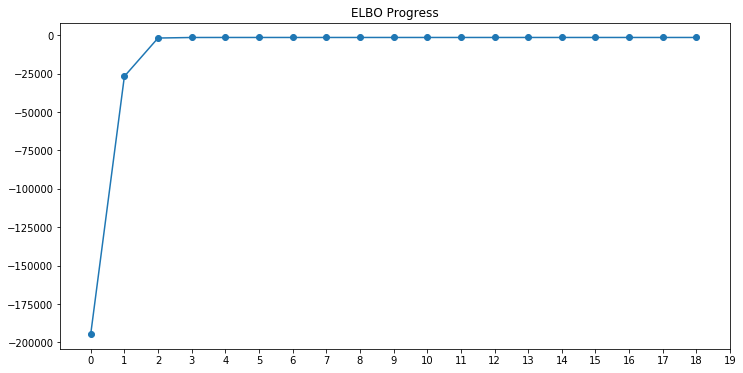

In [338]:
plt.plot(np.arange(len(gmm.elbos)),gmm.elbos, '-o', );
plt.xticks(np.arange(20))
plt.title('ELBO Progress');

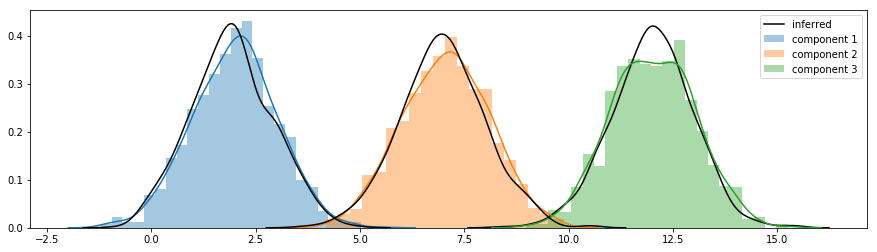

In [355]:
fig, ax = plt.subplots(figsize=(15, 4))
sns.distplot(X[:N], ax=ax, hist=True, norm_hist=True, label='component 1')
sns.distplot(np.random.normal(gmm.mean[0], 1, N), color='k', hist=False, kde=True)
sns.distplot(X[N:N*2], ax=ax, hist=True, norm_hist=True, label= 'component 2')
sns.distplot(np.random.normal(gmm.mean[1], 1, N), color='k', hist=False, kde=True)
sns.distplot(X[N*2:], ax=ax, hist=True, norm_hist=True, label='component 3')
sns.distplot(np.random.normal(gmm.mean[2], 1, N), color='k', hist=False, kde=True, label='inferred')

# Cavi for multivariate GMM


A Gaussian mixture models consists of components which are Gaussian. The components are mixed together according to mixture components. That is 

$$p(\v{x} \mid \{\theta_k\}) = \sum_k \pi_k N(\v{x} \mid \mu_k, \Sigma_k),$$

where $\pi_k$ are mixing coefficients and $\sum_k \pi_k = 1$. We can view the above formula from the latent variable point of view by introducing a latent variable $z$ having K possible states and encode $z$ using 1-of-K representation in which a particular element $z_k$ is equal to 1 and all other elements are equal to 0. The values of $z_k$ therefore satisify $z_k \in {0,1}$ and $\sum_k z_k = 1$. We define the joint distribution $p(\v{x}, \v{z})$ in terms of $p(\v{z})$ and $p(\v{x} \mid \v{z})$, whose expressions are

$$p(\v{z}) = \prod_{k=1}^{K}\pi_k^{z_k}$$

and 

$$p(\v{x} \mid \v{z}) = \prod_{k=1}^{K}\cal{N}(\mu_k, \Sigma_k)^{z_k}$$

Then we have for a single data point

$$p(\v{x, z}) = \prod_{k=1}^{K}\pi_k^{z_k}\cal{N}(\mu_k, \Sigma_k)^{z_k}$$

And for the whole data set $\v{X} = \{\v{x}_1, \dots, \v{x}_N\}$ we have the log-likelihood of complete data:
\begin{align}
\ln p(\v{X},\v{Z}) &=  \ln \prod_{n=1}^{N}\prod_{k=1}^{K}\pi_k^{z_{nk}} N(x_n | \mu_k, \Sigma_k)^{z_{nk}}\\
                    &= \sum_{n=1}^{N} \sum_{k=1}^{K} z_{nk}(\ln \pi_k + \ln N(x_n, | \mu_k, \Sigma_k))
\end{align}

We can view GMM graphically as

![graphical representation of GMM](gfx/gmm.pdf)

This is still a set up for EM. In VI, we will posit prior distributions over model parameters also. This leads to the following model

![VI graphical representation of GMM](gfx/gmm_vi.pdf)

In this new GMM model, we use precision matrix instead of covariance matrix for mathematical convenience. Let's derive the VI procedure for this model.



**Step 1: Write out the joint distribution**:

$$p(Z,X, \pi, \mu, \Sigma) = p(Z,X | \pi, \mu, \Lambda)p(\pi)p(\mu|\Lambda)p(\Lambda)$$

**Step 2: Posit a family of variatioan density to approximate $p(Z, \pi, \mu, \Lambda |X)$**:

We use mean-field models. That is $p(Z, \pi, \mu, \Lambda |X) \approx q(Z)q(\pi, \mu, \Lambda)$

**Step 3** **Derive the optimal components of variational density:**

For GMM, this will be computing $q^{*}(Z)$ and $q^{*}(\pi, \mu, \Lambda)$. This step normally provides an iterative procedure to update parameters of each component of the variational density.


In [34]:
class RandomVariable(object):
    """
    base class for random variables
    """

    def __init__(self):
        self.parameter = {}

    def __repr__(self):
        string = f"{self.__class__.__name__}(\n"
        for key, value in self.parameter.items():
            string += (" " * 4)
            if isinstance(value, RandomVariable):
                string += f"{key}={value:8}"
            else:
                string += f"{key}={value}"
            string += "\n"
        string += ")"
        return string

    def __format__(self, indent="4"):
        indent = int(indent)
        string = f"{self.__class__.__name__}(\n"
        for key, value in self.parameter.items():
            string += (" " * indent)
            if isinstance(value, RandomVariable):
                string += f"{key}=" + value.__format__(str(indent + 4))
            else:
                string += f"{key}={value}"
            string += "\n"
        string += (" " * (indent - 4)) + ")"
        return string

    def fit(self, X, **kwargs):
        """
        estimate parameter(s) of the distribution

        Parameters
        ----------
        X : np.ndarray
            observed data
        """
        self._check_input(X)
        if hasattr(self, "_fit"):
            self._fit(X, **kwargs)
        else:
            raise NotImplementedError

    def pdf(self, X):
        """
        compute probability density function
        p(X|parameter)

        Parameters
        ----------
        X : (sample_size, ndim) np.ndarray
            input of the function

        Returns
        -------
        p : (sample_size,) np.ndarray
            value of probability density function for each input
        """
        self._check_input(X)
        if hasattr(self, "_pdf"):
            return self._pdf(X)
        else:
            raise NotImplementedError

    def draw(self, sample_size=1):
        """
        draw samples from the distribution

        Parameters
        ----------
        sample_size : int
            sample size

        Returns
        -------
        sample : (sample_size, ndim) np.ndarray
            generated samples from the distribution
        """
        assert isinstance(sample_size, int)
        if hasattr(self, "_draw"):
            return self._draw(sample_size)
        else:
            raise NotImplementedError

    def _check_input(self, X):
        assert isinstance(X, np.ndarray)

class VariationalGaussianMixture(RandomVariable):

    def __init__(self, n_components=1, alpha0=None, m0=None, W0=1., dof0=None, beta0=1.):
        """
        construct variational gaussian mixture model
        Parameters
        ----------
        n_components : int
            maximum numnber of gaussian components
        alpha0 : float
            parameter of prior dirichlet distribution
        m0 : float
            mean parameter of prior gaussian distribution
        W0 : float
            mean of the prior Wishart distribution
        dof0 : float
            number of degrees of freedom of the prior Wishart distribution
        beta0 : float
            prior on the precision distribution
        """
        super().__init__()
        self.n_components = n_components
        if alpha0 is None:
            self.alpha0 = 1 / n_components
        else:
            self.alpha0 = alpha0
        self.m0 = m0
        self.W0 = W0
        self.dof0 = dof0
        self.beta0 = beta0

    def _init_params(self, X):
        sample_size, self.ndim = X.shape
        self.alpha0 = np.ones(self.n_components) * self.alpha0
        if self.m0 is None:
            self.m0 = np.mean(X, axis=0)
        else:
            self.m0 = np.zeros(self.ndim) + self.m0
        self.W0 = np.eye(self.ndim) * self.W0
        if self.dof0 is None:
            self.dof0 = self.ndim

        self.component_size = sample_size / self.n_components + np.zeros(self.n_components)
        self.alpha = self.alpha0 + self.component_size
        self.beta = self.beta0 + self.component_size
        indices = np.random.choice(sample_size, self.n_components, replace=False)
        self.mu = X[indices]
        self.W = np.tile(self.W0, (self.n_components, 1, 1))
        self.dof = self.dof0 + self.component_size

    @property
    def alpha(self):
        return self.parameter["alpha"]

    @alpha.setter
    def alpha(self, alpha):
        self.parameter["alpha"] = alpha

    @property
    def beta(self):
        return self.parameter["beta"]

    @beta.setter
    def beta(self, beta):
        self.parameter["beta"] = beta

    @property
    def mu(self):
        return self.parameter["mu"]

    @mu.setter
    def mu(self, mu):
        self.parameter["mu"] = mu

    @property
    def W(self):
        return self.parameter["W"]

    @W.setter
    def W(self, W):
        self.parameter["W"] = W

    @property
    def dof(self):
        return self.parameter["dof"]

    @dof.setter
    def dof(self, dof):
        self.parameter["dof"] = dof

    def get_params(self):
        return self.alpha, self.beta, self.mu, self.W, self.dof

    def _fit(self, X, iter_max=100):
        self._init_params(X)
        for _ in range(iter_max):
            params = np.hstack([p.flatten() for p in self.get_params()])
            r = self._variational_expectation(X)
            self._variational_maximization(X, r)
            if np.allclose(params, np.hstack([p.flatten() for p in self.get_params()])):
                break

    def _variational_expectation(self, X):
        d = X[:, None, :] - self.mu
        maha_sq = -0.5 * (
            self.ndim / self.beta
            + self.dof * np.sum(
                np.einsum("kij,nkj->nki", self.W, d) * d, axis=-1))
        ln_pi = digamma(self.alpha) - digamma(self.alpha.sum())
        ln_Lambda = digamma(0.5 * (self.dof - np.arange(self.ndim)[:, None])).sum(axis=0) + self.ndim * np.log(2) + np.linalg.slogdet(self.W)[1]
        ln_r = ln_pi + 0.5 * ln_Lambda + maha_sq
        ln_r -= logsumexp(ln_r, axis=-1)[:, None]
        r = np.exp(ln_r)
        return r

    def _variational_maximization(self, X, r):
        self.component_size = r.sum(axis=0)
        Xm = (X.T.dot(r) / self.component_size).T
        d = X[:, None, :] - Xm
        S = np.einsum('nki,nkj->kij', d, r[:, :, None] * d) / self.component_size[:, None, None]
        self.alpha = self.alpha0 + self.component_size
        self.beta = self.beta0 + self.component_size
        self.mu = (self.beta0 * self.m0 + self.component_size[:, None] * Xm) / self.beta[:, None]
        d = Xm - self.m0
        self.W = np.linalg.inv(
            np.linalg.inv(self.W0)
            + (self.component_size * S.T).T
            + (self.beta0 * self.component_size * np.einsum('ki,kj->kij', d, d).T / (self.beta0 + self.component_size)).T)
        self.dof = self.dof0 + self.component_size

    def classify(self, X):
        """
        index of highest posterior of the latent variable
        Parameters
        ----------
        X : (sample_size, ndim) ndarray
            input
        Returns
        -------
        output : (sample_size, n_components) ndarray
            index of maximum posterior of the latent variable
        """
        return np.argmax(self._variational_expectation(X), 1)

    def classify_proba(self, X):
        """
        compute posterior of the latent variable
        Parameters
        ----------
        X : (sample_size, ndim) ndarray
            input
        Returns
        -------
        output : (sample_size, n_components) ndarray
            posterior of the latent variable
        """
        return self._variational_expectation(X)

    def student_t(self, X):
        nu = self.dof + 1 - self.ndim
        L = (nu * self.beta * self.W.T / (1 + self.beta)).T
        d = X[:, None, :] - self.mu
        maha_sq = np.sum(np.einsum('nki,kij->nkj', d, L) * d, axis=-1)
        return (
            gamma(0.5 * (nu + self.ndim))
            * np.sqrt(np.linalg.det(L))
            * (1 + maha_sq / nu) ** (-0.5 * (nu + self.ndim))
            / (gamma(0.5 * nu) * (nu * np.pi) ** (0.5 * self.ndim)))

    def _pdf(self, X):
        return (self.alpha * self.student_t(X)).sum(axis=-1) / self.alpha.sum()


In [35]:
x1 = np.random.normal(size=(100, 2))
x1 += np.array([-5, -5])
x2 = np.random.normal(size=(100, 2))
x2 += np.array([5, -5])
x3 = np.random.normal(size=(100, 2))
x3 += np.array([0, 5])
x_train = np.vstack((x1, x2, x3))

x0, x1 = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
x = np.array([x0, x1]).reshape(2, -1).T

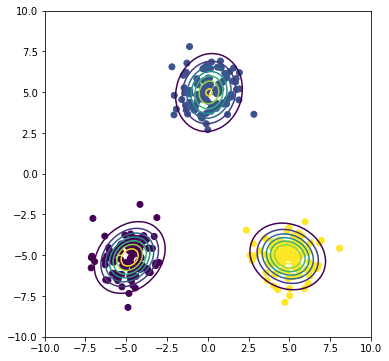

In [36]:
vgmm = VariationalGaussianMixture(n_components=6)
vgmm.fit(x_train)

plt.scatter(x_train[:, 0], x_train[:, 1], c=vgmm.classify(x_train))
plt.contour(x0, x1, vgmm.pdf(x).reshape(100, 100))
plt.xlim(-10, 10, 100)
plt.ylim(-10, 10, 100)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [37]:
vgmm = VariationalGaussianMixture(n_components=6)
vgmm._init_params(x_train)
params = np.hstack([param.flatten() for param in vgmm.get_params()])
fig = plt.figure()
colors = np.array(["r", "orange", "y", "g", "b", "purple"])
frames = []
for _ in range(100):
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.gca().set_aspect('equal', adjustable='box')
    r = vgmm._variational_expectation(x_train)
    imgs = [plt.scatter(x_train[:, 0], x_train[:, 1], c=colors[np.argmax(r, -1)])]
    for i in range(vgmm.n_components):
        if vgmm.component_size[i] > 1:
            imgs.append(plt.scatter(vgmm.mu[i, 0], vgmm.mu[i, 1], 100, colors[i], "X", lw=2, edgecolors="white"))
    frames.append(imgs)
    vgmm._variational_maximization(x_train, r)
    new_params = np.hstack([param.flatten() for param in vgmm.get_params()])
    if np.allclose(new_params, params):
        break
    else:
        params = np.copy(new_params)
plt.close()
plt.rcParams['animation.html'] = 'html5'
anim = animation.ArtistAnimation(fig, frames)
anim

# GMM using Stan - Probablistic Programming

As we already saw, programming variational inference for GMM is tedious and if somebody read your code, chances are they will not understand. In this section, we introduce Stan a probabilistic programming framework that allows us to decouple building models and performing inferences on them.


In [38]:
gmm_model = """
data {
    int<lower=0> N; // number of data points in dataset
    int<lower=0> K; // number of mixture components
    int<lower=0> D; // dimension
    vector[D] x[N]; // observations
}

transformed_data {
    vector<lower=0>[K] alpha0_vec;
    for (k in 1:K) {               // convert a scalar dirichlet prior 1/K
        alpha0_vec[k] = 1.0/K;     // to a vector
    }
}

paramaters {
    simplex[K] theta; // mixing proportions
    vector[D] = mu[K]; // locations of mixture components
    vector<lower=0>[D] sigma[K]; // standard deviations of mixture components
}

model {
    // priors
    theta ~ dirichlet(alpha0_vec);
    for (k in 1:K) {
        mu[k] ~ normal(0.0, 1.0/sigma[k]);
        sigma[k] ~ inv_gamma(1.0, 1.0);
    }
    
    // likelihood
    for (n in 1:N) {
        real ps[K];
        for (k in 1:K) {
            ps[k] = log(theta[k]) + normal_log(x[n], mu[k], sigma[k]);
        }
        increment_log_prob(log_sum_exp(ps));
    }
}
"""


# Appendix

### Wishart distribution

This distribution is the conjugate prior for the precision matrix of a multivariate Gaussian.

$$W(\boldsymbol{\Lambda}|\boldsymbol{W}, \nu) = B(\boldsymbol{W, \nu})|\boldsymbol{\Lambda}|^{(\nu-D-1)/2}exp(-\frac{1}{2}Tr(\boldsymbol{W}^{-1}\boldsymbol{\Lambda}))$$



The important thing here is:

- $\boldsymbol{W}$ is a $D \times D$ symmetric, positive defnite matrix
- $\nu$ is called the *number of degrees of freedom** of the distribution and is restricted to $\nu > D - 1$ to ensure the normalization factor is well-defined (Bishop)
- In one dimension, the Wishart distribution becomes $Gamma(\lambda |a,b)$, where $a=\nu/2$ and $b= 1/2W$:

$$Gamma(\lambda|a,b) = \frac{1}{\Gamma(a)}b^{a}\lambda^{a-1}e^{-b\lambda}$$
- $E[\boldsymbol{\Lambda}] = \nu\boldsymbol{W}$

### Einstein summation
Einstein summation is a way to perform summation of products along axes of tensors. A *tensor* is just a multi-dimensional matrix, at least from a computer scientist's perspective.

The benefits of einstein summation is multi-fold, but in short, it alleviates us from thinking of computation in multidimensional space, which can be very confusing. 

The graphics are copied from [here](https://obilaniu6266h16.wordpress.com/2016/02/04/einstein-summation-in-numpy/).

You can invoke numpy's einstein as follows:

![how to use](gfx/einsum-invocation.png)



The first input to ``np.einsum`` is the subscripts strings which provides labels for axes for tensors, $arg0, \dots, argn$. It has two parts that are separated by an arrow, part1 -> part2. part1 contains labels of input tensors and part2 contains label of output tensors. The following graphics illustrate this idea.

![](gfx/einsum-fmtstring.png)

Here labels of input tensors are separated by commas. Note that if the input or output tensors are scalars then its axis label is an empty string. Let consider three examples:

![](gfx/einsum-fmtstringcomplete.png)

The first einstein summation ``s = np.einsum("a->", v)`` is equivalent to ``np.sum(v)`` where ``v`` is a vector.

In [12]:
v = np.array([1,2,3])
np.einsum("a->", v)

6

The second ``T = np.einsum("ij->ji", M) is equivalent to a transpose of matrix ``M``

In [15]:
M = np.array([[1,2], [3,4]])
M.T

array([[1, 3],
       [2, 4]])

In [16]:
np.einsum("ij->ji", M)

array([[1, 3],
       [2, 4]])

The third einstein summation ``C = np.einsum("ik,kj->ij", A, B)`` represents matrix multiplication A*B.

In [19]:
A = np.ones((2,2))
B = M
B

array([[1, 2],
       [3, 4]])

In [26]:
A @ B

array([[4., 6.],
       [4., 6.]])

In [21]:
C = np.einsum("ik,kj->ij", A, B)
C

array([[4., 6.],
       [4., 6.]])

We can think of ``np.einsum`` as nice replacement for for-loop code if we were to write the operation manually.

![](gfx/einsum-matrixmul.png)

With this visualization, we see that subscripts can be divided into two subsets:

- *Free indices* are the indices used in the output specification. They are associated with the outer for-loops.
- *Summation indices* are all other indices: those that appear in the argument specifications but not in the output specification. e.g., ``k`` in ``ik,kj->ij``

To use ``np.einsum``, we need to visualize the dimensions that along which summations are peformed. Let's consider how to express quadratic form $v^TQv$ as a einstein summation.

$$\underset{s}{\begin{bmatrix} v_1 \dots v_n \end{bmatrix}}\overset{s}{\begin{bmatrix} Q \end{bmatrix}} \underset{t}{\begin{bmatrix} v_1 \\ \vdots \\ v_n\end{bmatrix}}$$

To compute a quadratic form, we first multiply allong dimension s of $v^T$ and then use the result to perform summation along dimension t of v. So now we can use ``np.einsum("s, st, t->", v, Q, v)`` to compute teh quadractive form.

In [29]:
v = np.array([1,2])
Q = np.array([[1,2],[2,1]])

In [32]:
# quadratic form
np.dot(v,Q).dot(v)

13

In [33]:
np.einsum("s,st,t->", v, Q,v)

13